In [130]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import geopandas
from shapely import wkt, wkb
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/xakaton-train/xakaton_train.csv
/kaggle/input/final-dataset/xakaton_test_with_graf_with_set_vrycnyu.csv
/kaggle/input/final-dataset/xakaton_train_with_graf_with_set_vrycnyu.csv
/kaggle/input/xakaton-test/xakaton_test.csv


# Загружаем финальный датасет, состоящий из графа дорог, камер и дорожной сети

In [2]:
final_train = pd.read_csv('../input/final-dataset/xakaton_train_with_graf_with_set_vrycnyu.csv',
                          low_memory=False)
final_test = pd.read_csv('../input/final-dataset/xakaton_test_with_graf_with_set_vrycnyu.csv',
                         low_memory=False)

# xakaton_test, xakaton_train

In [320]:
xakaton_test = pd.read_csv('../input/xakaton-test/xakaton_test.csv')
xakaton_train = pd.read_csv('../input/xakaton-train/xakaton_train.csv')

# merge final_train и final_test т.к. есть пересечения

In [8]:
merge_final_train_final_test = final_train.merge(final_test, on='id')

In [9]:
print(final_train.shape)
print(final_test.shape)
print(merge_final_train_final_test.shape)

(875478, 43)
(87330, 42)
(1425, 84)


# Построим карту трейн и тест

In [32]:
dataset_train_geom = geopandas.GeoDataFrame()
dataset_test_geom = geopandas.GeoDataFrame()

In [29]:
%%time
dataset_train_geom['geometry_road'] = final_train['geom_buffer'].apply(wkt.loads)
dataset_train_geom['geometry_road'] = geopandas.GeoSeries(dataset_train_geom['geometry_road'])
dataset_test_geom['geometry_road'] = final_test['geom_buffer'].apply(wkt.loads)
dataset_test_geom['geometry_road'] = geopandas.GeoSeries(dataset_test_geom['geometry_road'])

CPU times: user 1min 28s, sys: 391 ms, total: 1min 29s
Wall time: 1min 29s


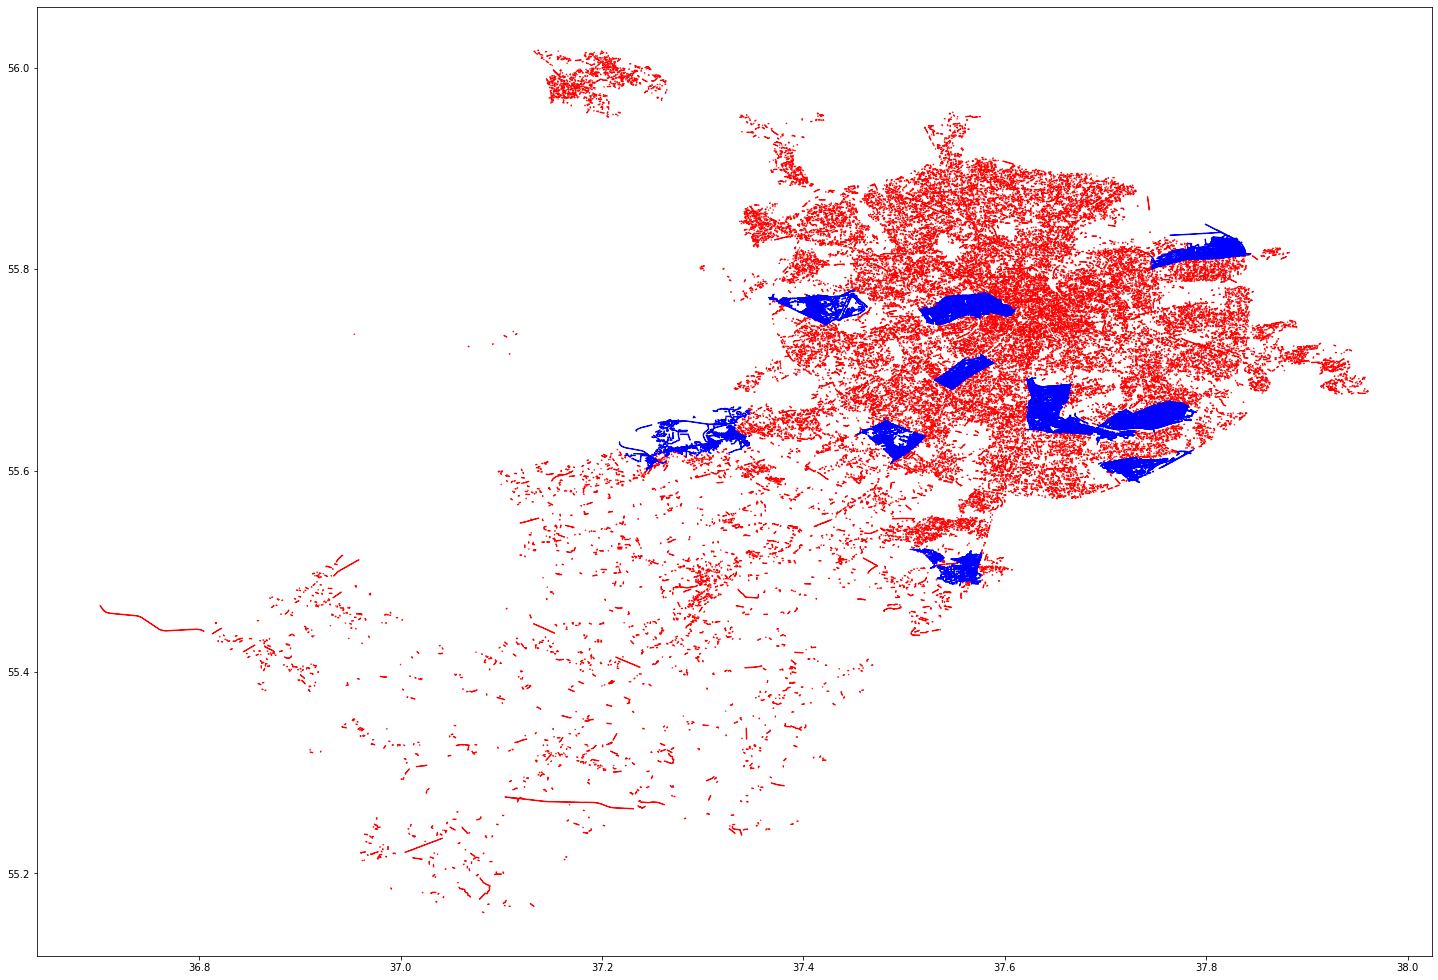

CPU times: user 36.1 s, sys: 33.6 ms, total: 36.1 s
Wall time: 36.1 s


In [126]:
%%time
road_train = dataset_train_geom['geometry_road'][0:875478:20]
road_test = dataset_test_geom['geometry_road'][0:87330:2]

fig, ax = plt.subplots(figsize=(25, 20))
road_train.plot(ax=ax, color="red",  edgecolor="red")
road_test.plot(ax=ax, color="blue",  edgecolor="blue")

plt.show()

# Отберем столбцы для построения модели: выбросим столбцы с геометрией и категориальные столбцы

In [194]:
 last_train = final_train.drop(['Unnamed: 0','id', 'EDGEID','Unnamed: 0.1', 'obj_cod',
                                'geom_buffer', 'geom_x', 'geom_y',
                                'rd_name', 'rd_e_name', 'rd_l_name'
                               ], axis=1)

In [195]:
X = last_train.drop(['victims'], axis=1)
y = last_train['victims']

# Поделим на трейн и тестовое множество

In [196]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) 

# Параметры моделей подбирались по gridsearchcv, метрика R2 чтобы отследить долю объясняемой моделью дисперсии

# LGBMRegressor

In [197]:
%%time
LGBM_best = LGBMRegressor(silent=False, random_state=42,
                          verbosity=2, max_depth=8, n_estimators=100, num_leaves=90)

LGBM_best.fit(X_train, y_train)

LGBM_predict = LGBM_best.predict(X_test)

print('MAE: ', mean_absolute_error(LGBM_predict, y_test))
print('MSE: ', mean_squared_error(LGBM_predict, y_test))
print('RMSE: ', mean_squared_error(LGBM_predict, y_test, squared=False))
print('r2_score: ', r2_score(LGBM_predict, y_test))

MAE:  0.11266531421882275
MSE:  0.12397176173483786
RMSE:  0.35209623930800205
r2_score:  -7.124075977294311
CPU times: user 26.4 s, sys: 440 ms, total: 26.9 s
Wall time: 7.1 s


# XGBRegressor

In [198]:
%%time

XGB_best = XGBRegressor(random_state=42, learning_rate=0.05,
                n_estimators=700, min_child_weight=2)

XGB_best.fit(X_train, y_train)

XGB_predict = XGB_best.predict(X_test)

print('MAE: ', mean_absolute_error(XGB_predict, y_test))
print('MSE: ', mean_squared_error(XGB_predict, y_test))
print('RMSE: ', mean_squared_error(XGB_predict, y_test, squared=False))
print('r2_score: ', r2_score(XGB_predict, y_test))

MAE:  0.11154010216579337
MSE:  0.11954163726299237
RMSE:  0.3457479389135854
r2_score:  -5.93818768146666
CPU times: user 35min 23s, sys: 8.45 s, total: 35min 31s
Wall time: 9min 13s


# CatBoostRegressor

In [203]:
%%time

CBR_best = CatBoostRegressor(random_state=42, silent=True, depth=11, iterations=100, learning_rate=0.05)

CBR_best.fit(X_train, y_train)

CBR_predict = CBR_best.predict(X_test)

print('MAE: ', mean_absolute_error(CBR_predict, y_test))
print('MSE: ', mean_squared_error(CBR_predict, y_test))
print('RMSE: ', mean_squared_error(CBR_predict, y_test, squared=False))
print('r2_score: ', r2_score(CBR_predict, y_test))

MAE:  0.11492374373724171
MSE:  0.12754113622512173
RMSE:  0.35712901901850785
r2_score:  -9.984595436186003
CPU times: user 2min 30s, sys: 3.36 s, total: 2min 34s
Wall time: 42.1 s


# Соединим три прогноза и посмотрим статистику

In [204]:
predict = pd.DataFrame({'LGBM_predict': CBR_predict, 'XGB_predict': XGB_predict, 'CBR_predict': LGBM_predict}) 

In [205]:
predict.describe() 

,LGBM_predict,XGB_predict,CBR_predict
count,218870.000000,218870.000000,218870.000000
mean,0.067129,0.066884,0.067042
std,0.107754,0.131259,0.123531
min,-0.014656,-0.378533,-0.311291
25%,0.016528,0.011542,0.013383
50%,0.027459,0.026070,0.024927
75%,0.095700,0.079171,0.079451
max,4.382854,7.766695,5.298006


# Посмотрим сколько пострадавших прогнозируют модели на тестовом множестве и сравним с y_test

In [206]:
print('LGBM_predict: ', predict['LGBM_predict'].values.sum())
print('LGBM_predict round: ', np.round(predict['LGBM_predict'],0).values.sum())
print('XGB_predict: ', predict['XGB_predict'].values.sum())
print('XGB_predict round: ', np.round(predict['XGB_predict'],0).values.sum())
print('CBR_predict: ', predict['CBR_predict'].values.sum())
print('CBR_predict round: ', np.round(predict['CBR_predict'],0).values.sum())
print('y_test: ', y_test.values.sum())

LGBM_predict:  14692.536551093124
LGBM_predict round:  1930.0
XGB_predict:  14639.047
XGB_predict round:  2631.0
CBR_predict:  14673.500915802791
CBR_predict round:  2561.0
y_test:  14551.0


# Посмотрим на распределение прогноза на тестовом множестве

In [209]:
pred_dist = pd.DataFrame({'LGBM_value_counts':  np.round(predict['LGBM_predict'],0).value_counts(),
                         'XGB_value_counts':  np.round(predict['XGB_predict'],0).value_counts(),
                         'CBR_value_counts':  np.round(predict['CBR_predict'],0).value_counts(),
                         })

In [210]:
pred_dist

,LGBM_value_counts,XGB_value_counts,CBR_value_counts
0.0,217085.0,216567,216581.0
1.0,1671.0,2094,2082.0
2.0,89.0,135,159.0
3.0,19.0,45,36.0
4.0,6.0,21,7.0
5.0,NaN,4,5.0
6.0,NaN,1,NaN
7.0,NaN,2,NaN
8.0,NaN,1,NaN


# LGBM_best.feature_importances_

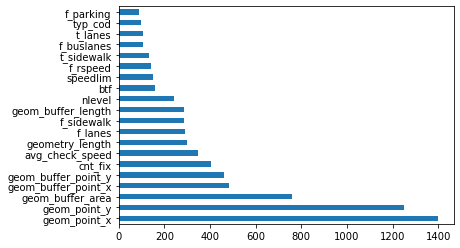

In [211]:
feat_importances_LGBM_best = pd.Series(LGBM_best.feature_importances_, index=X.columns)
feat_importances_LGBM_best.nlargest(20).plot(kind='barh')

# XGB_best.feature_importances_

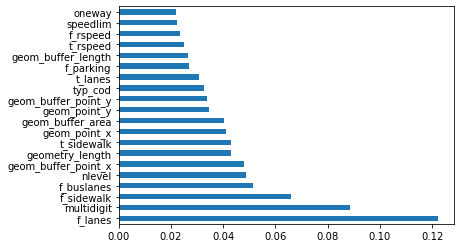

In [212]:
feat_importances_XGB_best = pd.Series(XGB_best.feature_importances_, index=X.columns)
feat_importances_XGB_best.nlargest(20).plot(kind='barh')

# CBR_best.feature_importances_

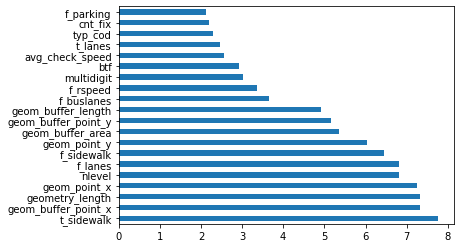

In [213]:
feat_importances_CBR_best = pd.Series(CBR_best.feature_importances_, index=X.columns)
feat_importances_CBR_best.nlargest(20).plot(kind='barh')

# Делаем прогноз для xakaton_test

In [214]:
last_test = final_test.drop(['Unnamed: 0','id', 'EDGEID','Unnamed: 0.1', 'obj_cod',
                                'geom_buffer', 'geom_x', 'geom_y',
                                'rd_name', 'rd_e_name', 'rd_l_name'
                                                  ], axis=1)

In [222]:
pred_test = pd.DataFrame({'LGBM_best': CBR_best.predict(last_test),
                     'XGB_best': LGBM_best.predict(last_test),
                     'CBR_best': XGB_best.predict(last_test)})

In [223]:
pred_test.describe()

,LGBM_best,XGB_best,CBR_best
count,87330.000000,87330.000000,87330.000000
mean,0.074772,0.077104,0.093813
std,0.121379,0.145957,0.180301
min,-0.006390,-0.306307,-0.168240
25%,0.019953,0.012830,0.013194
50%,0.032106,0.026583,0.031048
75%,0.098116,0.087169,0.099957
max,4.226549,4.616404,5.183647


# Опять же посмотрим распределение значений

In [225]:
pred_test_dist = pd.DataFrame({'LGBM_value_counts':  np.round(pred_test['LGBM_best'],0).value_counts(),
                         'XGB_value_counts':  np.round(pred_test['XGB_best'],0).value_counts(),
                         'CBR_value_counts':  np.round(pred_test['CBR_best'],0).value_counts(),
                         })

In [228]:
pred_test_dist

,LGBM_value_counts,XGB_value_counts,CBR_value_counts
0.0,86484.0,85817,84411
1.0,790.0,1419,2780
2.0,36.0,64,101
3.0,14.0,22,31
4.0,6.0,6,4
5.0,NaN,2,3


# Вывод, можно соединить модели, используя max()

In [321]:
ans_LGBM = []
ans_XGB = []
ans_CBR = []
xakaton_test['victims'] = 0
for i in range(len(pred)):
    ans_LGBM += [np.round(pred['LGBM_best'][i])]
        
    ans_XGB += [np.round(pred['XGB_best'][i])]
        
    ans_CBR  += [np.round(pred['CBR_best'][i])]

    xakaton_test['victims'][i] = max(ans_LGBM[i], ans_XGB[i], ans_CBR[i])

# помним, что еще есть merge_final_train_final_test, содержащий 1425 значений, последния проверка по нему

In [322]:
from sklearn.metrics import accuracy_score
comparison = xakaton_test.merge(merge_final_train_final_test, on='id')
accuracy_score(comparison['victims_x'], comparison['victims_y'])

0.8231578947368421

# Добавляем в xakaton_test данные из merge_final_train_final_test

In [323]:
prepare_ans = xakaton_test.merge(merge_final_train_final_test, on='id', how='left')
answer = prepare_ans.victims_y.fillna(prepare_ans.victims_x)
xakaton_test['victims'] = answer

In [325]:
xakaton_test.to_csv('prediction.csv')

# top 10 самых опасных мест

In [371]:
final_test_top = final_test.copy()
top10_test = final_test_top[xakaton_test['victims'] > 1]
top10_test_final = top10_test[['id', 'rd_name','victims', 'cnt_fix', 'f_buslanes', 'f_parking', 'bicyclanes', 't_sidewalk',
             'f_sidewalk','nlevel', 'typ_cod', 'f_lanes', 'avg_check_speed', 'splitter',
           ]].dropna().groupby('rd_name', as_index=False).sum()

In [374]:
top10_test_final[top10_test_final['victims'] > 5]

,rd_name,id,victims,cnt_fix,f_buslanes,f_parking,bicyclanes,t_sidewalk,f_sidewalk,nlevel,typ_cod,f_lanes,avg_check_speed,splitter
4,Боровское шоссе,51048926,10.0,0.0,0,0,0,4,4,10,38500,14,0.0,0
18,Рублевское шоссе,27567023,7.0,0.0,0,3,0,10,3,9,23100,11,0.0,0
26,просп. Маршала Жукова,44622107,12.0,0.0,4,4,0,4,4,8,30800,16,0.0,0


In [398]:
final_train_top = final_train.copy()
top10_train = final_train_top[final_train_top['victims'] > 1]
top10_train_final = top10_train[['id', 'rd_name','victims', 'cnt_fix',
             'f_buslanes', 'f_parking', 'bicyclanes', 't_sidewalk',
             'f_sidewalk','nlevel', 'typ_cod', 'f_lanes',
             'avg_check_speed', 'splitter',]].dropna().groupby('rd_name', as_index=False).agg({'victims':'sum',
                                                                                             'cnt_fix':'sum',
                                                                                             'typ_cod':'first',
                                                                                             'f_buslanes':'first',
                                                                                             'f_parking':'first',
                                                                                             'nlevel':'first',
                                                                                             'bicyclanes':'first',
                                                                                             'splitter':'first',
                                                                                             'avg_check_speed':'mean',
                                                                                              'splitter':'first',
                                                                                              'f_lanes':'first',
                                                                                              't_sidewalk':'first'})

In [390]:
top10_train_final[top10_train_final['victims'] > 110][['rd_name', 'id', 'victims']]

,rd_name,id,victims
47,3-е транспортное кольцо,473129531,177.0
177,Варшавское шоссе,685991082,213.0
186,Волгоградский просп.,860133323,277.0
262,Калужское шоссе,723161627,162.0
279,Киевское шоссе,649672211,187.0
330,Кутузовский просп.,315658006,130.0
356,Люблинская ул.,514079962,141.0
816,просп. Вернадского,369187444,199.0
955,ул. Лобачевского,260723307,112.0
1070,шоссе Энтузиастов,548066390,198.0


In [399]:
top10_train_final[top10_train_final['victims'] > 110]

,rd_name,victims,cnt_fix,typ_cod,f_buslanes,f_parking,nlevel,bicyclanes,splitter,avg_check_speed
47,3-е транспортное кольцо,177.0,2527284.5,7700,0,1,1,0,0,18.581356
177,Варшавское шоссе,213.0,305493.5,7700,0,0,3,0,1,3.597826
186,Волгоградский просп.,277.0,2100258.5,7700,0,4,2,0,0,10.637805
262,Калужское шоссе,162.0,22278.0,7700,0,0,2,0,1,1.448958
279,Киевское шоссе,187.0,303625.0,7700,0,0,1,0,1,8.815741
330,Кутузовский просп.,130.0,880753.5,7700,1,1,1,0,0,19.280303
356,Люблинская ул.,141.0,3742.5,7700,1,0,2,0,0,1.155682
816,просп. Вернадского,199.0,427566.0,7700,1,0,3,0,0,9.378409
955,ул. Лобачевского,112.0,60220.5,7700,1,1,3,0,0,5.937037
1070,шоссе Энтузиастов,198.0,117558.0,7700,1,1,2,0,0,3.539796
